In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import gensim
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import gensim.downloader as api
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from collections import Counter

C:\Users\ADMIN\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
def load_data(filepath, sep_type, col_1='label', col_2='message', has_header=True):
    """Load dataset from file and return a DataFrame, adjusting for headers."""
    if has_header:
        # Load with the first row as header
        return pd.read_csv(filepath, sep=sep_type, header=0)
    else:
        # Load without headers and assign column names
        return pd.read_csv(filepath, sep=sep_type, header=None, names=[col_1, col_2])

In [3]:
def preprocess_email(email):
    lemmatizer = WordNetLemmatizer()
    # Loại bỏ ký tự không mong muốn
    email_cleaned = re.sub('[^a-zA-Z]', ' ', email)
    # Chuyển thành chữ thường và tách từ
    email_cleaned = email_cleaned.lower().split()
    # Lemmatization
    email_cleaned = [lemmatizer.lemmatize(word, pos='v') for word in email_cleaned if not word in stopwords.words('english')]
    # email_cleaned = ' '.join(email_cleaned)
    
    return email_cleaned

In [4]:
def data_analist(data, corpus):
    df = pd.DataFrame(data)
    print('\n', df.isnull().sum())
    print('\n', df['label'].value_counts())
    print('\n', df.info())
    print(df.columns)
    print('\n', df['label'].value_counts()/len (df)*100)

In [5]:
def avg_word2vec(words, model):
    # Apply word2vec

    # Use this in case you don't have GoogleNews-vectors-negative300.bin.gz file.
    # vectors = [model.wv[word] for word in words if word in model.wv.index_to_key]
    
    vectors = [model[word] for word in words if word in model.key_to_index]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300)

In [6]:
def vectorize(email_cleaned, model):
  email_vector = avg_word2vec(email_cleaned, model)
  email_vector = email_vector.reshape(1, -1)
  return email_vector

In [7]:
def data_preparation(corpus, messages, model):
    X = []
    for i in range(len(corpus)):
        X.append(avg_word2vec(corpus[i], model))

    # Dependent feature
    y = pd.get_dummies(messages['label']).astype(int)
    y = y.iloc[:, 0].values

    df_list = [pd.DataFrame(X[i].reshape(1, -1)) for i in range(len(X))]
    df = pd.concat(df_list, ignore_index=True)
    df['Output'] = y
    df.dropna(inplace = True)

    # Independent feature

    X = df.drop('Output', axis=1)

    y = df['Output']

    return X, y

In [8]:
def predict_email(email, classifier, model):

    def isSpam(email):
      email_cleaned = preprocess_email(email)
      email_vector = vectorize(email_cleaned, model)
      predicted_label = classifier.predict(email_vector)
      print('Spam' if predicted_label[0] == 0 else 'Ham',' ---', email)

      # return email, 'Spam' if predicted_label[0] == 0 else 'Ham'

    results = []

    if(type(email) == str):
        isSpam(email)
      # results.append(isSpam(email))

    elif(type(email) == list):
      for corpus in email:
        isSpam(corpus)
        # results.append(isSpam(corpus))

    # Chuyển kết quả sang DataFrame
    # results_df = pd.DataFrame(results, columns=['Email', 'Label'])
    # print(results_df)

In [9]:
messages = load_data('SMSSpamCollection.txt', '\t', has_header=False)

# Load pre-trained model

In [10]:
# Data pre-processing
from gensim.models import KeyedVectors

corpus = [preprocess_email(email) for email in messages['message']]

# Use word2vec pre-trained model of Google
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

# Use this in case you don't have GoogleNews-vectors-negative300.bin.gz file.
# model = gensim.models.Word2Vec(
#     corpus,              # your tokenized corpus
#     vector_size=100,    # embedding size
#     window=5,           # context window size
#     min_count=5,        # include all words
#     sg=1,               # use Skip-Gram
#     workers=4,          # parallelization
#     epochs=10           # number of iterations
# )

In [11]:
data_analist(messages, corpus)


 label      0
message    0
dtype: int64

 label
ham     4825
spam     747
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

 None
Index(['label', 'message'], dtype='object')

 label
ham     86.593683
spam    13.406317
Name: count, dtype: float64


# Visualization

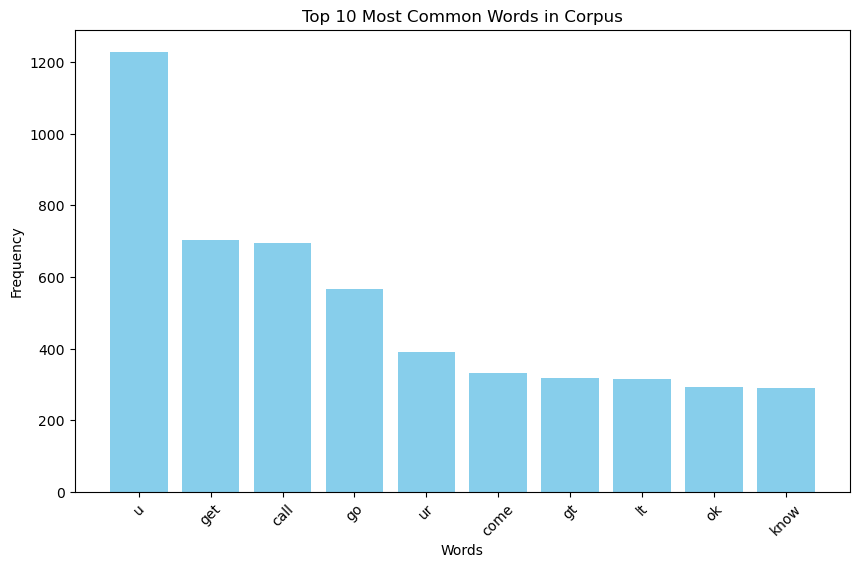

In [12]:
# Calculate word frequency
all_words = [word for email in corpus for word in email]
word_freq = Counter(all_words)
    
# Select the 10 most common words
most_common_words = word_freq.most_common(10)
words, frequencies = zip(*most_common_words)  # separate words and their counts
    
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words in Corpus')
plt.xticks(rotation=45)
plt.show()

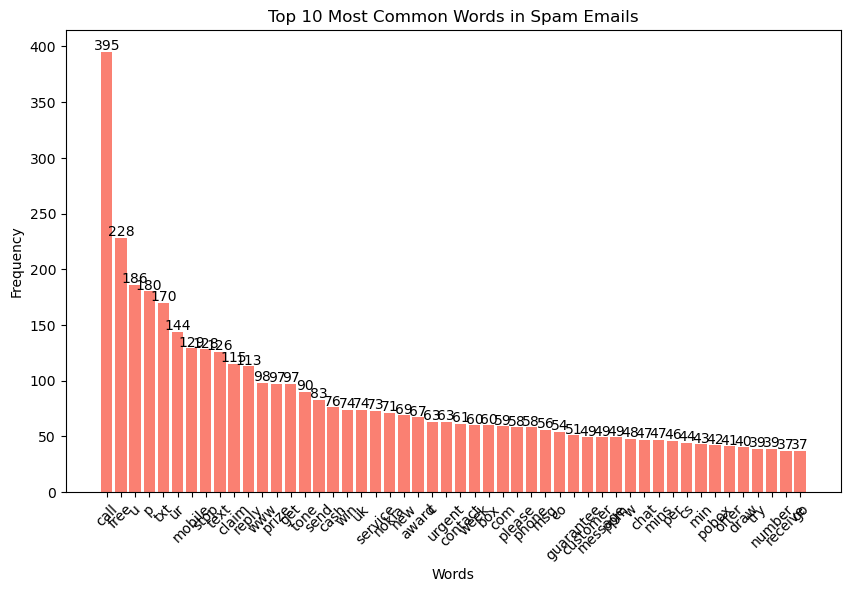

In [13]:
# Separate corpus into spam and ham messages
spam_corpus = [corpus[i] for i in range(len(corpus)) if messages['label'].iloc[i] == 'spam']
ham_corpus = [corpus[i] for i in range(len(corpus)) if messages['label'].iloc[i] == 'ham']
    
# Flatten lists and calculate word frequencies for spam and ham
spam_words = [word for email in spam_corpus for word in email]
spam_word_freq = Counter(spam_words)
    
# Get top 10 most common words in spam emails
spam_common_words = spam_word_freq.most_common(50)
spam_words, spam_frequencies = zip(*spam_common_words)
    
# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(spam_words, spam_frequencies, color='salmon')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words in Spam Emails')
plt.xticks(rotation=45)
    
# Add frequency values on top of each bar
for bar, freq in zip(bars, spam_frequencies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 1,  # position slightly below the top of each bar
                f'{freq}', ha='center', va='bottom', fontsize=10, color='black')
    
plt.show()

In [14]:
# Print top 50 most common words in spam emails with their frequencies
print("Top 50 Most Common Words in Spam Emails:")
for word, freq in spam_common_words:
    print(f"{word}: {freq}")

Top 50 Most Common Words in Spam Emails:
call: 395
free: 228
u: 186
p: 180
txt: 170
ur: 144
mobile: 129
stop: 128
text: 126
claim: 115
reply: 113
www: 98
prize: 97
get: 97
tone: 90
send: 83
cash: 76
win: 74
uk: 74
service: 73
nokia: 71
new: 69
award: 67
c: 63
urgent: 63
contact: 61
week: 60
box: 60
com: 59
please: 58
phone: 58
msg: 56
co: 54
guarantee: 51
customer: 49
message: 49
ppm: 49
w: 48
chat: 47
mins: 47
per: 46
cs: 44
min: 43
pobox: 42
offer: 41
draw: 40
try: 39
number: 39
receive: 37
go: 37


#  X Y Iimplement

In [15]:
X, y = data_preparation(corpus, messages, model)

# Train model

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

# Evaluate

In [17]:
from sklearn.metrics import accuracy_score, classification_report

In [18]:
y_pred = classifier.predict(X_test)

In [19]:
y_pred

array([1, 1, 1, ..., 1, 1, 0])

In [20]:
accuracy_score(y_test, y_pred)

0.9659192825112107

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       139
           1       0.99      0.97      0.98       976

    accuracy                           0.97      1115
   macro avg       0.91      0.94      0.93      1115
weighted avg       0.97      0.97      0.97      1115



# Predict

In [22]:
predict_email("Hey mohan, can we get together to watch footbal game tomorrow?", classifier, model)
predict_email('Get rich quick with our investment opportunity! Join now and start earning big profits!', classifier, model)

Ham  --- Hey mohan, can we get together to watch footbal game tomorrow?
Ham  --- Get rich quick with our investment opportunity! Join now and start earning big profits!


In [23]:
emails=[
    'Hey mohan, can we get together to watch footbal game tomorrow?',
    'hi, how are you?',
    'Upto 20% discount on parking, exclusive offer just for you. Dont miss this reward!',
    'i won free vacation , you can win click below link',
    "Hey Sarah, are you available for a coffee chat this weekend?",
    "Congratulations! You've been selected as the winner of a $1000 cash prize. Click the link to claim your reward now!"
    'Claim your exclusive discount code now and save 30% on your next purchase! Limited time offer!',
    "You've won a luxury vacation package! Click the link to claim your prize and enjoy a dream getaway!",
    'Get rich quick with our investment opportunity! Join now and start earning big profits!',
    'Hey there, how about catching up for lunch this weekend? It\'s been a while since we last met!',
    'Reminder: Your appointment with the doctor is scheduled for tomorrow at 10 AM. Please remember to bring any necessary documents.',
    'Invitation: Join us for a team-building event this Friday at the local park. Food and games provided!',
]

predict_email(emails, classifier, model)

Ham  --- Hey mohan, can we get together to watch footbal game tomorrow?
Ham  --- hi, how are you?
Spam  --- Upto 20% discount on parking, exclusive offer just for you. Dont miss this reward!
Spam  --- i won free vacation , you can win click below link
Spam  --- Hey Sarah, are you available for a coffee chat this weekend?
Spam  --- Congratulations! You've been selected as the winner of a $1000 cash prize. Click the link to claim your reward now!Claim your exclusive discount code now and save 30% on your next purchase! Limited time offer!
Spam  --- You've won a luxury vacation package! Click the link to claim your prize and enjoy a dream getaway!
Ham  --- Get rich quick with our investment opportunity! Join now and start earning big profits!
Ham  --- Hey there, how about catching up for lunch this weekend? It's been a while since we last met!
Ham  --- Reminder: Your appointment with the doctor is scheduled for tomorrow at 10 AM. Please remember to bring any necessary documents.
Ham  --- 

In [24]:
predict_email('free 1000 claim please kill self', classifier, model)

Spam  --- free 1000 claim please kill self


In [25]:
predict_email('It’s the last day of our sale. Shop now and save.', classifier, model)

Spam  --- It’s the last day of our sale. Shop now and save.


In [26]:
spam_email_contents = [
    "You have been selected to receive a $10,000 gift card from our exclusive rewards program!",
    "Your application has been pre-approved for a $50,000 loan with no credit check required!",
    "We have detected suspicious activity on your account.",
    "Looking for a way to earn money from the comfort of your home?",
    "You have been selected to receive a FREE cruise to the Bahamas!",
    "Your PayPal account has been temporarily suspended due to suspicious activity.",
    "You have been selected to win a brand-new iPhone 15!",
    "Invest in Bitcoin today and double your money within 48 hours!",
    "You have won a $500 Amazon gift card!",
    "Sign up today for a FREE trial and gain access to premium resources that will change your life."
]

predict_email(spam_email_contents, classifier, model)

Spam  --- You have been selected to receive a $10,000 gift card from our exclusive rewards program!
Spam  --- Your application has been pre-approved for a $50,000 loan with no credit check required!
Ham  --- We have detected suspicious activity on your account.
Ham  --- Looking for a way to earn money from the comfort of your home?
Spam  --- You have been selected to receive a FREE cruise to the Bahamas!
Spam  --- Your PayPal account has been temporarily suspended due to suspicious activity.
Spam  --- You have been selected to win a brand-new iPhone 15!
Ham  --- Invest in Bitcoin today and double your money within 48 hours!
Spam  --- You have won a $500 Amazon gift card!
Ham  --- Sign up today for a FREE trial and gain access to premium resources that will change your life.


In [27]:
spam_email_contents = [
    "Congratulations! You've won a $1000 gift card.",
    "Claim your exclusive discount code for 50% off your next purchase!",
    "You've been selected for a free vacation package!",
    "Get a limited-time offer: $500 off your next order!",
    "Your entry has won a cash prize! Click here to claim it.",
    "Unlock your special coupon code for a free trial!",
    "You've received a reward for being a loyal customer!",
    "Act now! This offer expires in 24 hours.",
    "Congratulations on your recent purchase! Here’s a bonus discount.",
    "Claim your free gift now! No purchase necessary.",
     "You have been selected to receive a $10,000 gift card from our exclusive rewards program!",
    "Your application has been pre-approved for a $50,000 loan with no credit check required!",
    "We have detected suspicious activity on your account.",
    "Looking for a way to earn money from the comfort of your home?",
    "You have been selected to receive a FREE cruise to the Bahamas!",
    "Your PayPal account has been temporarily suspended due to suspicious activity.",
    "You have been selected to win a brand-new iPhone 15!",
    "Invest in Bitcoin today and double your money within 48 hours!",
    "You have won a $500 Amazon gift card!",
    "Sign up today for a FREE trial and gain access to premium resources that will change your life."
]

predict_email(spam_email_contents, classifier, model)

Spam  --- Congratulations! You've won a $1000 gift card.
Spam  --- Claim your exclusive discount code for 50% off your next purchase!
Spam  --- You've been selected for a free vacation package!
Ham  --- Get a limited-time offer: $500 off your next order!
Spam  --- Your entry has won a cash prize! Click here to claim it.
Spam  --- Unlock your special coupon code for a free trial!
Spam  --- You've received a reward for being a loyal customer!
Spam  --- Act now! This offer expires in 24 hours.
Spam  --- Congratulations on your recent purchase! Here’s a bonus discount.
Spam  --- Claim your free gift now! No purchase necessary.
Spam  --- You have been selected to receive a $10,000 gift card from our exclusive rewards program!
Spam  --- Your application has been pre-approved for a $50,000 loan with no credit check required!
Ham  --- We have detected suspicious activity on your account.
Ham  --- Looking for a way to earn money from the comfort of your home?
Spam  --- You have been selected to

In [28]:
email_samples = [
    "Congratulations! You've won a $1000 gift card.",
    "Hi team, can we schedule a meeting for next week to discuss the project?",
    "Claim your exclusive discount code for 50% off your next purchase!",
    "Don't forget to submit your expense reports by Friday.",
    "You've been selected for a free vacation package!",
    "The project deadline has been moved to next month.",
    "Get a limited-time offer: $500 off your next order!",
    "Attached is the presentation for our upcoming client meeting.",
    "Your entry has won a cash prize! Click here to claim it.",
    "Let's review the budget proposal during our next meeting.",
    "Unlock your special coupon code for a free trial!",
    "Please find the updated document for your review.",
    "You've received a reward for being a loyal customer!",
    "Reminder: Our team-building event is scheduled for Saturday.",
    "Act now! This offer expires in 24 hours.",
    "Thank you for your feedback on the last project.",
    "Congratulations on your recent purchase! Here’s a bonus discount.",
    "Can you send me the latest sales figures by end of day?",
    "Claim your free gift now! No purchase necessary.",
    "I appreciate your hard work and dedication to this project."
]

predict_email(email_samples, classifier, model)

Spam  --- Congratulations! You've won a $1000 gift card.
Ham  --- Hi team, can we schedule a meeting for next week to discuss the project?
Spam  --- Claim your exclusive discount code for 50% off your next purchase!
Ham  --- Don't forget to submit your expense reports by Friday.
Spam  --- You've been selected for a free vacation package!
Ham  --- The project deadline has been moved to next month.
Ham  --- Get a limited-time offer: $500 off your next order!
Spam  --- Attached is the presentation for our upcoming client meeting.
Spam  --- Your entry has won a cash prize! Click here to claim it.
Ham  --- Let's review the budget proposal during our next meeting.
Spam  --- Unlock your special coupon code for a free trial!
Spam  --- Please find the updated document for your review.
Spam  --- You've received a reward for being a loyal customer!
Ham  --- Reminder: Our team-building event is scheduled for Saturday.
Spam  --- Act now! This offer expires in 24 hours.
Ham  --- Thank you for your f

In [29]:
new_data = load_data('email_classification.csv', ',')

new_corpus = [preprocess_email(email) for email in new_data['email']]

data_analist(new_data, new_corpus)

X_new, y_new = data_preparation(new_corpus, new_data, model)

X_predict = [text for text in new_data['email']]

y_pred_new = classifier.predict(X_new)

print(accuracy_score(y_new, y_pred_new))

predict_email(X_predict, classifier, model)


 email    0
label    0
dtype: int64

 label
ham     100
spam     79
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   179 non-null    object
 1   label   179 non-null    object
dtypes: object(2)
memory usage: 2.9+ KB

 None
Index(['email', 'label'], dtype='object')

 label
ham     55.865922
spam    44.134078
Name: count, dtype: float64
0.6424581005586593
Spam  --- Upgrade to our premium plan for exclusive access to premium content and features.
Ham  --- Happy holidays from our team! Wishing you joy and prosperity this season.
Ham  --- We're hiring! Check out our career opportunities and join our dynamic team.
Spam  --- Your Amazon account has been locked. Click here to verify your account information.
Ham  --- Your opinion matters! Take our survey and help us enhance your experience.
Spam  --- Your payment has been receive

In [30]:
# import imaplib
# import email
# from email.header import decode_header

# # Thông tin đăng nhập
# username = ""
# password = ""

# # Kết nối đến Gmail IMAP server
# mail = imaplib.IMAP4_SSL("imap.gmail.com")

# # Đăng nhập
# mail.login(username, password)

# # Chọn hộp thư (thường là 'inbox')
# mail.select("inbox")

# # Tìm kiếm 8 email gần nhất (hoặc số lượng bạn muốn)
# status, mail_messages = mail.search(None, "ALL")
# email_ids = mail_messages[0].split()[-100:]

# # Danh sách để lưu tiêu đề email
# email_samples = []
# subjects = []

# # Lặp qua từng email
# for email_id in email_ids:
#     # Lấy email bằng ID
#     res, msg = mail.fetch(email_id, "(RFC822)")
#     msg = email.message_from_bytes(msg[0][1])

#     # Giải mã tiêu đề
#     subject, encoding = decode_header(msg["Subject"])[0]
#     if isinstance(subject, bytes):
#         subject = subject.decode(encoding if encoding else 'utf-8')

#     # Lưu tiêu đề vào danh sách
#     subjects.append(subject)

# # Đăng xuất
# mail.logout()

# # Gọi hàm dự đoán spam

In [31]:
# import imaplib
# import email
# from email.header import decode_header
# import re

# # Thông tin đăng nhập - 
# # T xóa của t rồi, nhớ tự điền ---------------------
# username = ""
# password = ""

# # Kết nối đến Gmail IMAP server
# mail = imaplib.IMAP4_SSL("imap.gmail.com")
# mail.login(username, password)
# mail.select("inbox")

# # Tìm kiếm 8 email gần nhất
# status, messages = mail.search(None, "ALL")
# email_ids = messages[0].split()[-8:]  # Lấy 8 email gần nhất

# # Danh sách lưu tiêu đề và nội dung email
# subjects = []
# contents = []

# # Hàm làm sạch nội dung email, loại bỏ link, hình ảnh, và nối dòng
# def clean_email_content(content):
#     # Loại bỏ các đường link
#     content = re.sub(r"http\S+|www\S+|https\S+", "", content, flags=re.MULTILINE)
#     # Loại bỏ các thẻ HTML của hình ảnh
#     content = re.sub(r"<img[^>]*>", "", content, flags=re.MULTILINE)
#     # Loại bỏ ký tự xuống dòng và khoảng trắng thừa
#     content = re.sub(r'\r\n|\n', ' ', content)
#     content = re.sub(r'\s+', ' ', content).strip()
#     return content

# # Lặp qua từng email
# for email_id in email_ids:
#     # Lấy email bằng ID
#     res, msg = mail.fetch(email_id, "(RFC822)")
#     msg = email.message_from_bytes(msg[0][1])

#     # Giải mã tiêu đề
#     subject, encoding = decode_header(msg["Subject"])[0]
#     if isinstance(subject, bytes):
#         subject = subject.decode(encoding if encoding else 'utf-8')
#     subjects.append(subject)

#     # Lấy và làm sạch nội dung email
#     body = ""
#     if msg.is_multipart():
#         for part in msg.walk():
#             content_type = part.get_content_type()
#             content_disposition = str(part.get("Content-Disposition"))
#             # Chỉ lấy nội dung dạng text, bỏ qua các tệp đính kèm
#             if content_type == "text/plain" and "attachment" not in content_disposition:
#                 body += part.get_payload(decode=True).decode()
#     else:
#         body = msg.get_payload(decode=True).decode()

#     # Làm sạch và nối trực tiếp nội dung
#     clean_body = clean_email_content(body)
#     contents.append(clean_body)

# # Đăng xuất
# mail.logout()

# # Gọi hàm dự đoán spam dựa trên nội dung email
# predict_email(contents, classifier, model)

In [32]:
# predict_email(subjects, classifier, model)

In [33]:
import imaplib
import email
from email.header import decode_header
import re

# Thông tin đăng nhập
username = "tuanbenten24@gmail.com"
password = "uxwg rsjz mzdr amey"

# username = "nguyenhoanglong0165@gmail.com"
# password = "cyaz ewkp ewjt vmck"

# Kết nối đến Gmail IMAP server
mail = imaplib.IMAP4_SSL("imap.gmail.com")
mail.login(username, password)
mail.select("inbox")

# Tìm kiếm 8 email gần nhất
status, messages = mail.search(None, "ALL")
email_ids = messages[0].split()[-8:]  # Lấy 8 email gần nhất

emails = []

# Hàm làm sạch nội dung email
def clean_email_content(content):
    # Loại bỏ các đường link
    content = re.sub(r"http\S+|www\S+|https\S+", "", content, flags=re.MULTILINE)
    # Loại bỏ các thẻ HTML của hình ảnh
    content = re.sub(r"<img[^>]*>", "", content, flags=re.MULTILINE)
    # Loại bỏ ký tự xuống dòng và khoảng trắng thừa
    content = re.sub(r'\r\n|\n', ' ', content)
    content = re.sub(r'\s+', ' ', content).strip()
    return content

# Lặp qua từng email
for email_id in email_ids:
    # Lấy email bằng ID
    res, msg = mail.fetch(email_id, "(RFC822)")
    msg = email.message_from_bytes(msg[0][1])

    # Giải mã tiêu đề
    subject, encoding = decode_header(msg["Subject"])[0]
    if isinstance(subject, bytes):
        subject = subject.decode(encoding if encoding else 'utf-8')

    # Lấy và làm sạch nội dung email
    body = ""
    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))
            # Chỉ lấy nội dung dạng text, bỏ qua các tệp đính kèm
            if content_type == "text/plain" and "attachment" not in content_disposition:
                body += part.get_payload(decode=True).decode()
    else:
        body = msg.get_payload(decode=True).decode()

    # Làm sạch và lưu thông tin email
    clean_body = clean_email_content(body)
    emails.append({"subject": subject, "content": clean_body})

# Đăng xuất
mail.logout()

# Gọi hàm dự đoán spam cho từng email
predictions = []
for email_data in emails:
    # Chuyển đổi nội dung email thành vector
    email_vector = vectorize(preprocess_email(email_data["content"]), model)

    # Dự đoán nhãn cho email
    prediction = classifier.predict(email_vector)
    # Gọi hàm dự đoán spam cho từng email
predictions = []
for email_data in emails:
    # Chuyển đổi nội dung email thành vector
    cleaned_email = preprocess_email(email_data["content"])
    print(cleaned_email)
    email_vector = vectorize(cleaned_email, model)
    print(email_vector)

    # Dự đoán nhãn cho email
    prediction = classifier.predict(email_vector)

    # Chuyển đổi dự đoán từ mảng 1D sang định dạng dễ đọc
    predictions.append('Spam' if prediction[0] == 0 else 'Ham')


# In ra thông tin từng email và dự đoán
for i, email_data in enumerate(emails):
    print("Subject:", email_data["subject"])
    print("Content:", email_data["content"])
    print("Prediction:", predictions[i])  # In ra dự đoán tương ứng
    print("-" * 40)

['matuy', 'order', 'complete', 'registration', 'hypixel', 'minecraft', 'server', 'map', 'need', 'confirm', 'account', 'follow', 'link', 'thank', 'register', 'hypixel', 'minecraft', 'server', 'map']
[[-1.99301578e-02 -1.03509083e-01 -4.89153201e-03  1.27040315e-02
  -7.51953125e-02  7.55320936e-02  5.12172170e-02 -6.03812076e-02
   5.90429977e-02 -1.71873905e-02 -2.34026220e-02  1.35672437e-02
  -2.07214355e-02  2.70560123e-02 -3.61306332e-02  1.32045195e-01
   5.10559082e-02  1.72094610e-02 -2.51639225e-02 -1.38275146e-01
   1.52640209e-01  6.57958984e-02 -7.25015923e-02  8.74208733e-02
   6.34504035e-02  2.26876400e-02 -3.55529785e-03  4.98155877e-02
   1.25754222e-01 -2.97415592e-02  6.86046062e-03 -6.89958856e-02
  -9.59777832e-02 -8.04530531e-02 -8.98088738e-02 -1.24912806e-01
   1.62737161e-01 -6.46493062e-02  8.94077867e-02  8.12290758e-02
   2.55824495e-02 -3.96074578e-02  7.11168572e-02  1.41187394e-02
   3.85175422e-02 -1.76042825e-01 -2.11225245e-02  2.93622701e-03
  -1.46571